# 05. Model Exploration

This notebook examines dozens of models to find one that produces a high silhouette score with a lower inertia value. Models examined include those with scaled and unscaled data, dimensionality reduction achieved via PCA applied or not applied, t-SNE - another dimensionality reduction technique applied or not. Additionally, it examines several text vectorization techniques including spaCy word embeddings, Count Vectorizer (CVEC), and Term Frequency-Inverse Document Frequency (TF-IDF).


In [1]:
# # If running in google colab:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# # if not already installed, spaCy is necessary to run the following cells
# !pip install -U spacy

In [86]:
# # Download en_core_web_lg for google colab
# !python -m spacy download en_core_web_lg

## Imports

In [87]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# KNN used to help determine epsilon value for DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [89]:
# # Importing the finalized concatinated dataframe

# # If running in google colab, use this import line:
# # Change to file location if necessary
# data1 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_1.json')
# data2 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_2.json')
# data3 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_3.json')
# data4 = pd.read_json('/content/drive/MyDrive/Python/tweet_vectors_4.json')

# # Use these lines if running locally
data1 = pd.read_json('../data/tweet_vectors_1.json')
data2 = pd.read_json('../data/tweet_vectors_2.json')
data3 = pd.read_json('../data/tweet_vectors_3.json')
data4 = pd.read_json('../data/tweet_vectors_4.json')


In [175]:
data = pd.concat([data1, data2, data3, data4], axis=0, sort=False)

# data = data.drop_duplicates()

In [176]:
# keeping only certain columns that will be used
columns_keep =['screen_name','state','position','name','party','tweet_count','text_concat_clean','liststring','vectors', 'text_length', 'word_length']

data = data[columns_keep]

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   screen_name        521 non-null    object
 1   state              521 non-null    object
 2   position           521 non-null    object
 3   name               521 non-null    object
 4   party              521 non-null    object
 5   tweet_count        521 non-null    int64 
 6   text_concat_clean  521 non-null    object
 7   liststring         521 non-null    object
 8   vectors            521 non-null    object
 9   text_length        521 non-null    int64 
 10  word_length        521 non-null    int64 
dtypes: int64(3), object(8)
memory usage: 48.8+ KB


## K-Means using spaCy word embeddings

In [178]:
# Create X
X = data['vectors']
X = np.matrix(X.tolist())

# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Applying PCA to word vectors
# choosing n components
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc = pca_sc.fit_transform(X_sc)

# TSNE w/ scaled data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# TSNE w/ PCA
X_tsne_pca = tsne.fit_transform(X_pca)


# TSNE w/ scaled data
tsne = TSNE(n_components=2)
X_tsne_sc = tsne.fit_transform(X_sc)

# TSNE w/ scaled, pca
X_tsne_sc_pca = tsne.fit_transform(X_pca_sc)


#### Function to find K-Means Silhouette Scores and Inertia Values

In [179]:
def find_scores_k(X_choice):
    # looking at multiple silhouette scores

    # set up empty list to store scores
    scores_sil = []
    scores_ine = []

    for k in range(2, 10):
        # instantiate model
        km = KMeans(n_clusters=k, random_state=516)

        # fit the model
        km.fit(X_choice)

        # Get silhouette score for each k
        sil_score = silhouette_score(X_choice, km.labels_)
        scores_sil.append([k, sil_score])
        # Get inertia score for each k
        scores_ine.append([k, km.inertia_])

    # save as a df for viewing
    scores_df1 = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])
    scores_df2 = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

    scores_df = pd.merge(scores_df1, scores_df2, on = "k", how = "inner")

    # looking at silhouette scores
    return scores_df

#### Finding K-Means Silhouette Scores

In [180]:
find_scores_k(X)

,k,silhouette,inertia
0,2,0.193815,5.544692
1,3,0.197627,4.864931
2,4,0.133714,4.446016
3,5,0.126664,4.183683
4,6,0.099811,3.993605
5,7,0.105426,3.808600
6,8,0.096575,3.694921
7,9,0.098449,3.609658


In [181]:
find_scores_k(X_sc)

,k,silhouette,inertia
0,2,0.145578,133277.604537
1,3,0.152195,120224.051937
2,4,0.104908,111469.378279
3,5,0.102501,106872.873553
4,6,0.085407,103303.352122
5,7,0.090254,99814.911645
6,8,0.090050,97412.936165
7,9,0.070327,95289.671106


In [182]:
find_scores_k(X_pca)

,k,silhouette,inertia
0,2,0.205296,5.200229
1,3,0.210197,4.520672
2,4,0.144089,4.102136
3,5,0.147089,3.858603
4,6,0.127774,3.653423
5,7,0.116031,3.470882
6,8,0.108097,3.345886
7,9,0.092942,3.265344


In [183]:
find_scores_k(X_pca_sc)

,k,silhouette,inertia
0,2,0.154256,125583.425787
1,3,0.160163,112547.889598
2,4,0.112625,103797.173259
3,5,0.106093,99204.323586
4,6,0.091787,95714.386346
5,7,0.083167,92361.790120
6,8,0.081849,89784.840978
7,9,0.079139,87555.121082


In [184]:
find_scores_k(X_tsne)

,k,silhouette,inertia
0,2,0.528872,49197.659414
1,3,0.420348,33619.849076
2,4,0.388312,26990.201380
3,5,0.392564,21400.027517
4,6,0.399232,16866.340447
5,7,0.397965,14431.119494
6,8,0.399430,12023.420537
7,9,0.397678,10501.042988


In [185]:
find_scores_k(X_tsne_sc)

,k,silhouette,inertia
0,2,0.465802,77072.502927
1,3,0.420529,52848.729865
2,4,0.396849,39262.662607
3,5,0.407698,29922.646010
4,6,0.392826,25521.372601
5,7,0.376105,21643.513535
6,8,0.381299,18622.555849
7,9,0.378978,16510.009704


In [186]:
find_scores_k(X_tsne_pca)

,k,silhouette,inertia
0,2,0.457642,61114.193918
1,3,0.395418,41381.927991
2,4,0.416833,30407.960828
3,5,0.430105,22380.496603
4,6,0.429653,18902.337920
5,7,0.407615,15770.320584
6,8,0.402073,13854.995420
7,9,0.389051,12199.124595


In [187]:
find_scores_k(X_tsne_sc_pca)

,k,silhouette,inertia
0,2,0.422195,96260.609748
1,3,0.403975,65748.235241
2,4,0.431522,43824.719398
3,5,0.388963,36304.730684
4,6,0.407944,29247.985046
5,7,0.404543,23542.488969
6,8,0.390270,21074.189214
7,9,0.369595,19009.441410


#### Function to plot Silhouette Scores

In [188]:
# plotting the silhouette scores across k's

def plot_sil_score(X_choice):
  
    # looking at multiple silhouette scores

    # set up empty list to store scores
    scores_sil = []

    for k in range(2, 10):
        # instantiate model
        km = KMeans(n_clusters=k, random_state=516)

        # fit the model
        km.fit(X_choice)

        # Get silhouette score for each k
        sil_score = silhouette_score(X_choice, km.labels_)
        scores_sil.append([k, sil_score])

    # save as a df for viewing
    scores_df = pd.DataFrame(scores_sil, columns = ['k', 'silhouette'])

    plt.figure(figsize=(12,9))

    plt.plot(scores_df['k'], scores_df['silhouette'])

    plt.title(f'Silhouette Scores over K')

    plt.show()

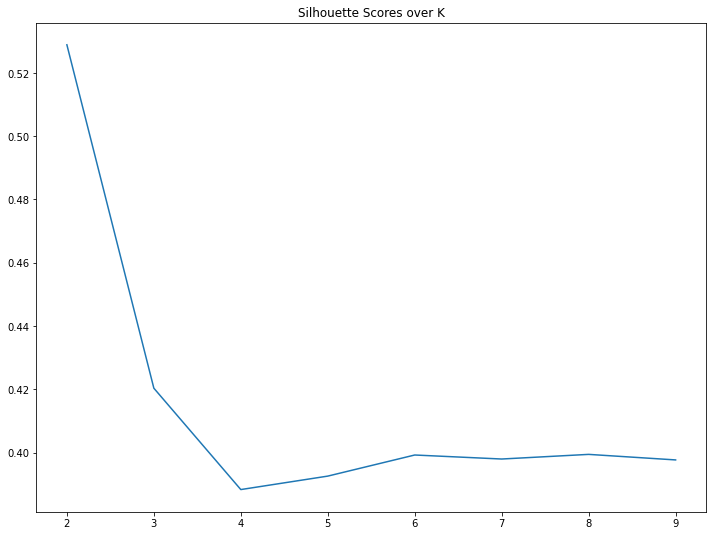

In [189]:
plot_sil_score(X_tsne)

#### Function to plot Inertia Scores

In [190]:
# plotting the inertia scores across k's
# Using the 'elbow' method to help find a good k
# https://medium.com/@cmukesh8688/k-means-clustering-in-machine-learning-252130c85e23

def plot_inertia_score(X_choice):
  
    # looking at multiple silhouette scores

    # set up empty list to store scores
    scores_ine = []

    for k in range(2, 10):
        # instantiate model
        km = KMeans(n_clusters=k, random_state=516)

        # fit the model
        km.fit(X_choice)

        # Get inertia score for each k
        scores_ine.append([k, km.inertia_])

    # save as a df for viewing
    scores_df = pd.DataFrame(scores_ine, columns = ['k', 'inertia'])

    plt.figure(figsize=(12,9))

    plt.plot(scores_df['k'], scores_df['inertia'])

    plt.title(f'Inertia Scores over K')

    plt.show()

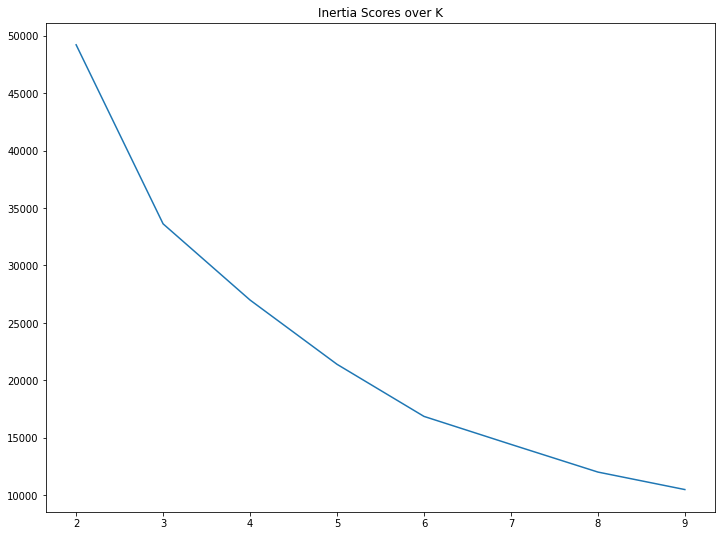

In [192]:
plot_inertia_score(X_tsne)

#### Function to plot Clusters and Centroids

In [193]:
def plot_k_clusters(k, X_choice):
    km = KMeans(n_clusters=k, random_state=516)
    km.fit(X_choice)
    km_means = km.predict(X_choice)

    plt.figure(figsize=(12,8))

    plt.scatter([X_choice[:, 0]], [X_choice[:, 1]], c=km_means, s=25, cmap='crest')

    centers = km.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)

    plt.title(f'Clusters and Centroids:\n k = {k}', size=20)
    plt.show()

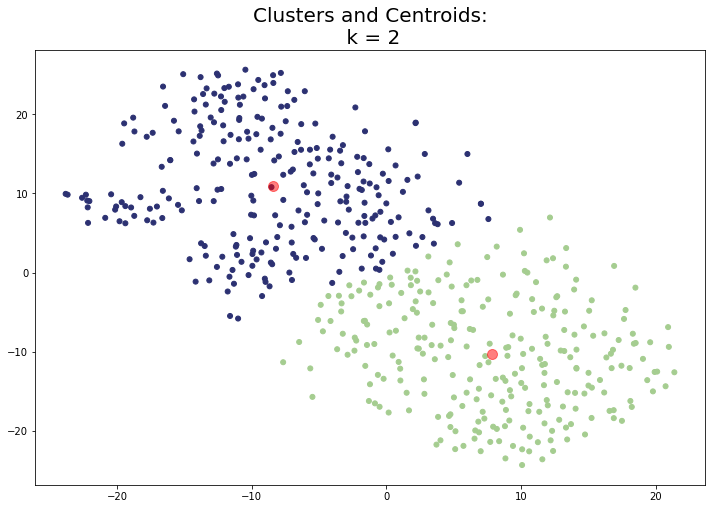

In [194]:
# plotting for best model found from silhouette scores, inertia values
plot_k_clusters(2, X_tsne)

#### Exporting best spaCy model

In [262]:
# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters = 2, random_state=516)

km.fit(X_tsne)

print(set(km.labels_))

print(silhouette_score(X_tsne, km.labels_))

print('--------------------')

data['km_label'] = km.labels_

print(data['km_label'].value_counts())

print('--------------------')

# print(km.cluster_centers_)

# adding km labels back on the dataframe
data['km_label'] = km.labels_

{0, 1}
0.52887195
--------------------
1    262
0    259
Name: km_label, dtype: int64
--------------------


#### Function to use K Nearest Neighbors to find a good epsilon score for DBSCAN

In [196]:
# Function Using KNN to help find a good epsilon score
# to be used with DBSCAN
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

def find_epsilon(X_choice, knn_n):

    k_neighbors = NearestNeighbors(n_neighbors=knn_n)

    k_nbrs = k_neighbors.fit(X_choice)

    distances, indices = k_nbrs.kneighbors(X_choice)

    distances = np.sort(distances, axis=0)

    distances = distances[:,1]

    plt.figure(figsize=(12,8))

    plt.plot(distances)

    plt.title(f'Using KNN to Help Find Epsilon Score\n knn: {knn_n}', size=20)

    plt.show()

In [197]:
# Function to find silhouette score for DBSCAN using the epsilon
# fount from the graphs (elbow test)
# min_samples is set to natural log of number of points to be clustered
# HELP: https://askdatascience.com/646/dbscan-algorithm-how-should-choose-optimal-minimum-points
# HELP: https://moonbooks.org/Articles/How-to-calculate-the-natural-logarithm-in-python-/

def find_scores_db(X_choice, eps_value):

    dbscan = DBSCAN(eps=eps_value, min_samples=np.log(len(data))) #change the epsilon

    dbscan.fit(X_choice)

    print(set(dbscan.labels_))

    print(silhouette_score(X, dbscan.labels_))

    print('--------------------')

    data['dbscan_label'] = dbscan.labels_

    print(data['dbscan_label'].value_counts())

    print('--------------------')


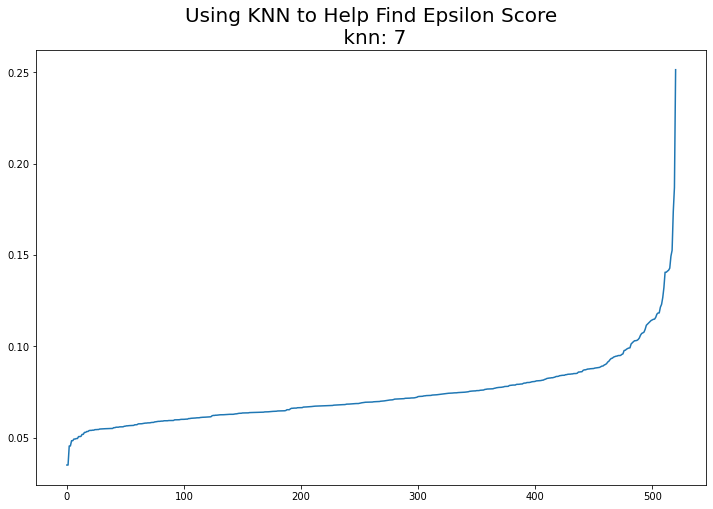

In [198]:
find_epsilon(X, 7)

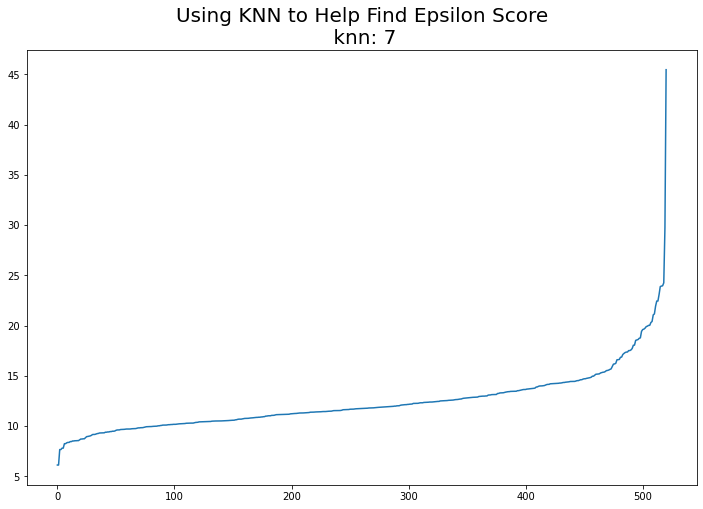

In [199]:
find_epsilon(X_sc, 7)

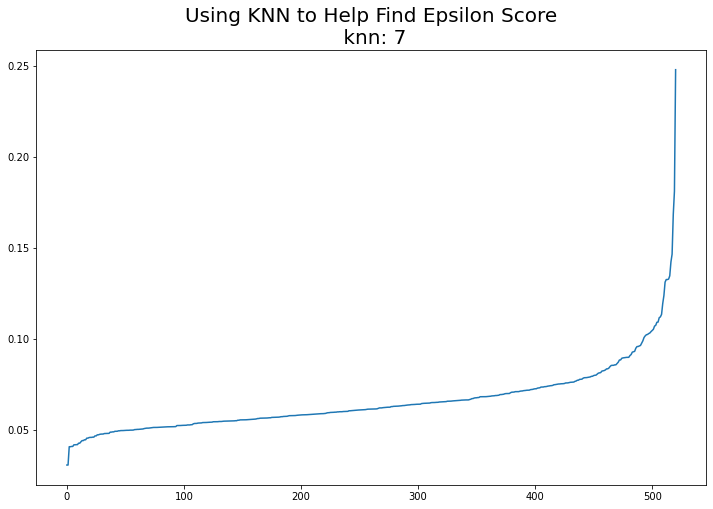

In [200]:
find_epsilon(X_pca, 7)

In [201]:
find_scores_db(X_pca, 0.11)

{0, -1}
0.4268770363886056
--------------------
 0    506
-1     15
Name: dbscan_label, dtype: int64
--------------------


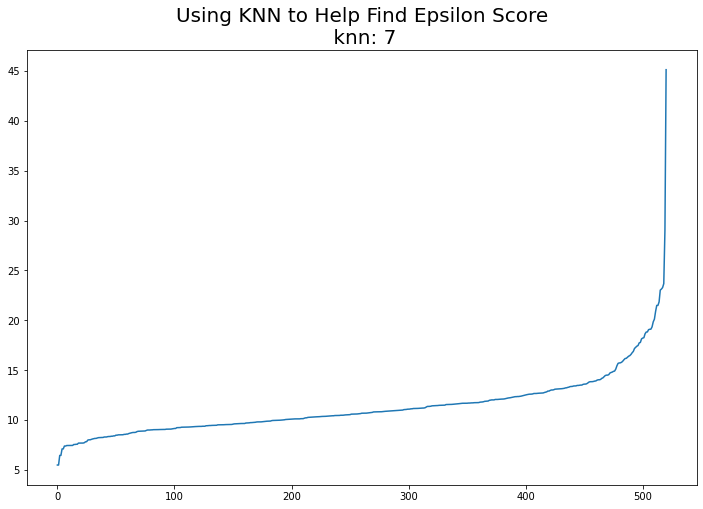

In [202]:
find_epsilon(X_pca_sc, 7)

In [203]:
find_scores_db(X_pca_sc, 20)

{0, -1}
0.46572057601623346
--------------------
 0    510
-1     11
Name: dbscan_label, dtype: int64
--------------------


#### DBSCAN did not yield good silhouette scores and so was not found as a suitable candidate for a final model.

## CVEC and TF-IDF

In [204]:
# Create X
X_ = data['liststring']

In [206]:
# instantiating CVEC
cvec = CountVectorizer(max_features = 250, ngram_range = (1, 1))

# instantiating TF-IDF
tvec = TfidfVectorizer(max_features = 200, ngram_range = (1, 1))

In [207]:
# creating a CVEC based dataframe
X_c = pd.DataFrame(cvec.fit_transform(X_).toarray(), columns = cvec.get_feature_names())

# creating a TF-IDF dataframe
X_t = pd.DataFrame(tvec.fit_transform(X_).toarray(), columns = tvec.get_feature_names())

In [208]:
# Applying the Standard Scaler to word vectors
sc = StandardScaler()
X_sc_c = sc.fit_transform(X_c) # CVEC
X_sc_t = sc.fit_transform(X_t) # TF-IDF

# Applying PCA to word vectors
pca = PCA(n_components = 0.95)
X_pca_c = pca.fit_transform(X_c) # CVEC
X_pca_t = pca.fit_transform(X_t) # TF-IDF

# Applying standard scaler, then applying PCA to word vectors
pca_sc = PCA(n_components = 0.95)
X_pca_sc_c = pca_sc.fit_transform(X_sc_c) # CVEC
X_pca_sc_t = pca_sc.fit_transform(X_sc_t) # TF-IDF

# TSNE w/ scaled data
tsne = TSNE(n_components=2)
X_tsne_c = tsne.fit_transform(X_c) # CVEC
X_tsne_t = tsne.fit_transform(X_t) # TF-IDF

# TSNE w/ pca applied data
tsne = TSNE(n_components=2)
X_tsne_pca_c = tsne.fit_transform(X_pca_c) # CVEC
X_tsne_pca_t = tsne.fit_transform(X_pca_t) # TF-IDF

# TSNE w/ scaled data, pca applied
X_tsne_pca_sc_c = tsne.fit_transform(X_pca_sc_c) # CVEC
X_tsne_pca_sc_t = tsne.fit_transform(X_pca_sc_t) # TF-IDF

#### Silhouette scores and Inertia Values for CVEC models

In [209]:
find_scores_k(X_c)

,k,silhouette,inertia
0,2,0.506212,4.701210e+08
1,3,0.399271,3.680191e+08
2,4,0.316501,3.216538e+08
3,5,0.302238,2.996552e+08
4,6,0.281498,2.825113e+08
5,7,0.281057,2.642791e+08
6,8,0.210064,2.526450e+08
7,9,0.201986,2.398323e+08


In [210]:
find_scores_k(X_sc_c)

,k,silhouette,inertia
0,2,0.464234,83403.035187
1,3,0.367641,67739.745546
2,4,0.292690,59018.860248
3,5,0.245528,55490.055286
4,6,0.215860,53010.416973
5,7,0.208334,50726.182829
6,8,0.133588,49083.352287
7,9,0.131501,47864.761411


In [211]:
find_scores_k(X_pca_c)

,k,silhouette,inertia
0,2,0.524990,4.339890e+08
1,3,0.423834,3.319910e+08
2,4,0.344426,2.857006e+08
3,5,0.324399,2.637613e+08
4,6,0.310452,2.470744e+08
5,7,0.310787,2.284859e+08
6,8,0.263444,2.165738e+08
7,9,0.218945,2.050507e+08


In [212]:
find_scores_k(X_pca_sc_c)

,k,silhouette,inertia
0,2,0.482040,77004.589223
1,3,0.396119,61358.780286
2,4,0.317108,52629.306757
3,5,0.259426,49030.839475
4,6,0.229910,46545.548505
5,7,0.179070,44454.659746
6,8,0.180483,43003.130316
7,9,0.145201,41162.323867


In [213]:
find_scores_k(X_tsne_c)

,k,silhouette,inertia
0,2,0.538552,63533.309523
1,3,0.464034,37307.819506
2,4,0.416735,26844.736482
3,5,0.443445,20432.150657
4,6,0.420113,16575.222484
5,7,0.403412,13777.677616
6,8,0.405865,11808.070679
7,9,0.405121,10162.080013


In [214]:
find_scores_k(X_tsne_sc_c)

,k,silhouette,inertia
0,2,0.556149,131131.286086
1,3,0.497382,73864.000312
2,4,0.461782,48604.316997
3,5,0.410015,39665.126880
4,6,0.391578,34069.314622
5,7,0.384666,28854.717877
6,8,0.397961,23655.178176
7,9,0.394616,20801.992365


In [215]:
find_scores_k(X_tsne_pca_c)

,k,silhouette,inertia
0,2,0.566631,117774.621006
1,3,0.470454,72517.247088
2,4,0.440510,48914.312199
3,5,0.458132,37363.682444
4,6,0.434470,30757.615342
5,7,0.407803,25748.660181
6,8,0.397000,22188.620627
7,9,0.409536,19448.133067


In [216]:
find_scores_k(X_tsne_pca_sc_c)

,k,silhouette,inertia
0,2,0.546595,50542.696278
1,3,0.486449,29142.475676
2,4,0.418736,21552.062093
3,5,0.436092,17124.653491
4,6,0.400282,13934.428937
5,7,0.413107,11459.388303
6,8,0.412412,9657.052513
7,9,0.414408,8362.618522


#### Plotting CVEC clusters and Centroids with the best model

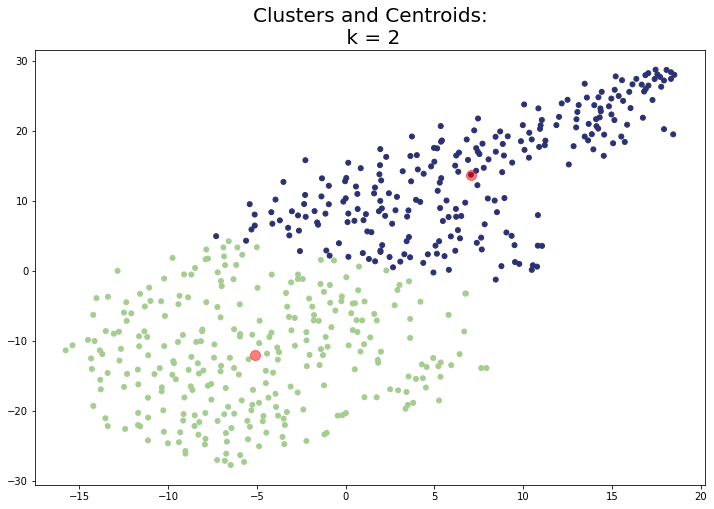

In [263]:
plot_k_clusters(2, X_tsne_pca_sc_c)

#### Plotting silhouette scores for best CVEC model

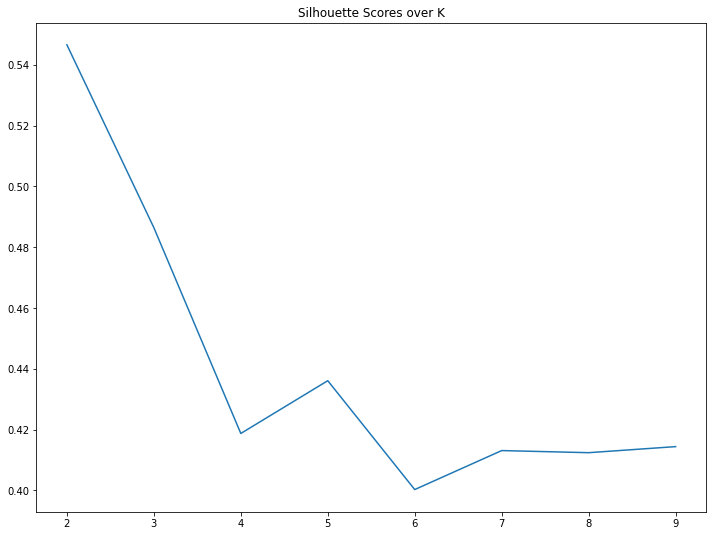

In [264]:
plot_sil_score(X_tsne_pca_sc_c)

#### Plotting inertia values for best CVEC model

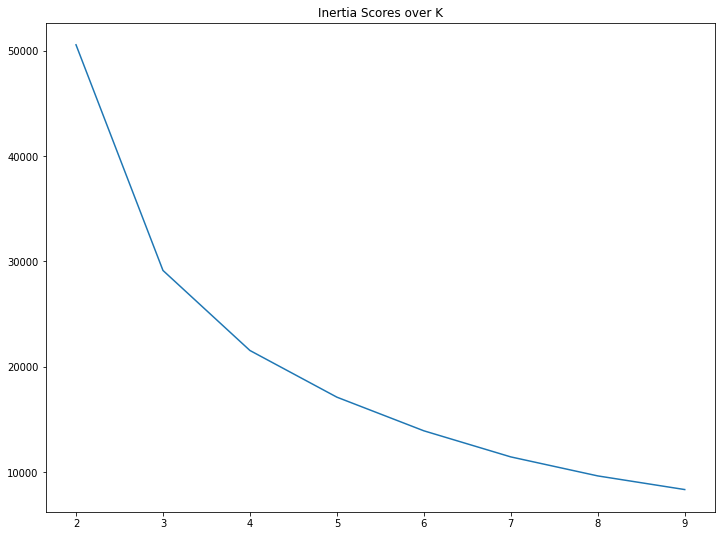

In [265]:
plot_inertia_score(X_tsne_pca_sc_c)

#### Silhouette scores and Inertia Values for TF-IDF models

In [220]:
find_scores_k(X_t)

,k,silhouette,inertia
0,2,0.118171,94.644079
1,3,0.108976,87.871240
2,4,0.080054,83.518805
3,5,0.084171,80.779474
4,6,0.064979,78.904075
5,7,0.060561,77.701454
6,8,0.056634,76.410285
7,9,0.056971,75.026443


In [221]:
find_scores_k(X_sc_t)

,k,silhouette,inertia
0,2,0.085987,94800.494951
1,3,0.070616,89721.615214
2,4,0.053444,87265.780918
3,5,0.045029,85366.426863
4,6,0.035050,84203.672318
5,7,0.032154,82865.659601
6,8,0.045450,82001.879143
7,9,0.033265,80707.751547


In [222]:
find_scores_k(X_pca_t)

,k,silhouette,inertia
0,2,0.124651,89.288831
1,3,0.120076,82.436943
2,4,0.085710,78.167313
3,5,0.085884,75.438487
4,6,0.068866,73.561616
5,7,0.064269,72.039945
6,8,0.060737,70.833391
7,9,0.048452,69.989813


In [223]:
find_scores_k(X_pca_sc_t)

,k,silhouette,inertia
0,2,0.090810,89661.227796
1,3,0.075133,84587.201210
2,4,0.056481,82131.774507
3,5,0.044083,80293.605405
4,6,0.036225,79047.113703
5,7,0.047083,77713.096867
6,8,0.036590,76328.848728
7,9,0.036538,75561.327441


In [224]:
find_scores_k(X_tsne_t)

,k,silhouette,inertia
0,2,0.475723,44560.759396
1,3,0.449152,26597.280675
2,4,0.450623,17969.752696
3,5,0.414081,14212.990579
4,6,0.417347,12225.012944
5,7,0.378586,10843.478210
6,8,0.368736,9478.672616
7,9,0.353708,8616.718024


In [225]:
find_scores_k(X_tsne_sc_t)

,k,silhouette,inertia
0,2,0.491700,43583.467867
1,3,0.452332,26546.493028
2,4,0.443521,18067.214106
3,5,0.405653,14455.221734
4,6,0.395743,12545.326534
5,7,0.381413,11088.445155
6,8,0.367013,9668.914924
7,9,0.361744,8474.978253


In [226]:
find_scores_k(X_tsne_pca_t)

,k,silhouette,inertia
0,2,0.483249,44747.263241
1,3,0.468100,26352.085775
2,4,0.443681,18401.527585
3,5,0.408471,14463.115771
4,6,0.405933,12368.782361
5,7,0.369610,10964.021552
6,8,0.388082,9749.389463
7,9,0.371606,8515.256779


In [227]:
find_scores_k(X_tsne_pca_sc_t)

,k,silhouette,inertia
0,2,0.399917,46761.772754
1,3,0.416390,29325.537710
2,4,0.403488,20299.432178
3,5,0.384907,15813.567750
4,6,0.353235,13527.994728
5,7,0.340908,11702.219975
6,8,0.362570,10107.229147
7,9,0.358647,8954.290356


#### Plotting clusters for the best TF-IDF model

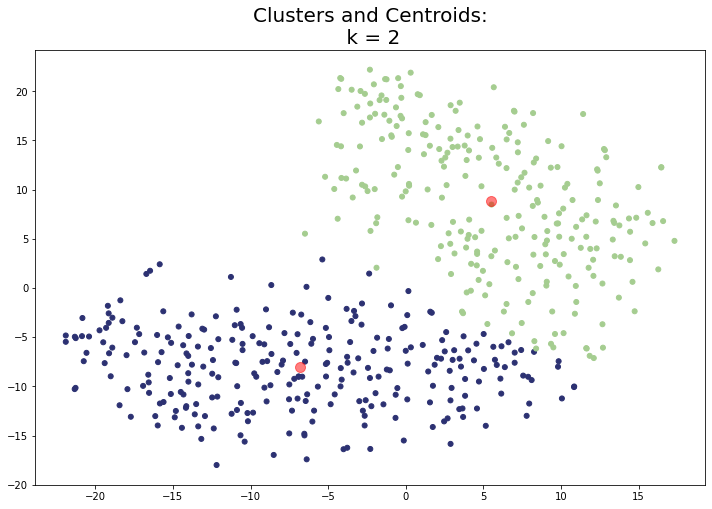

In [266]:
plot_k_clusters(2, X_tsne_sc_t)

#### Plotting Silhouette Scores for the best TF-IDF model

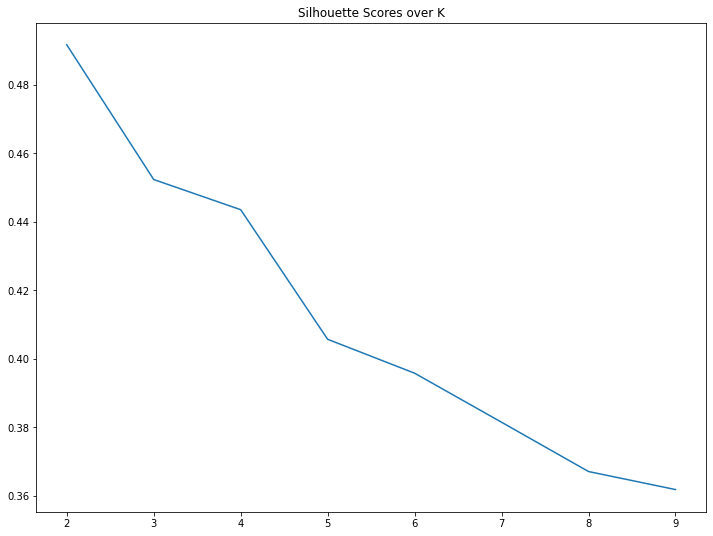

In [267]:
plot_sil_score(X_tsne_sc_t)

#### Plotting Inertia Values for the best TF-IDF model

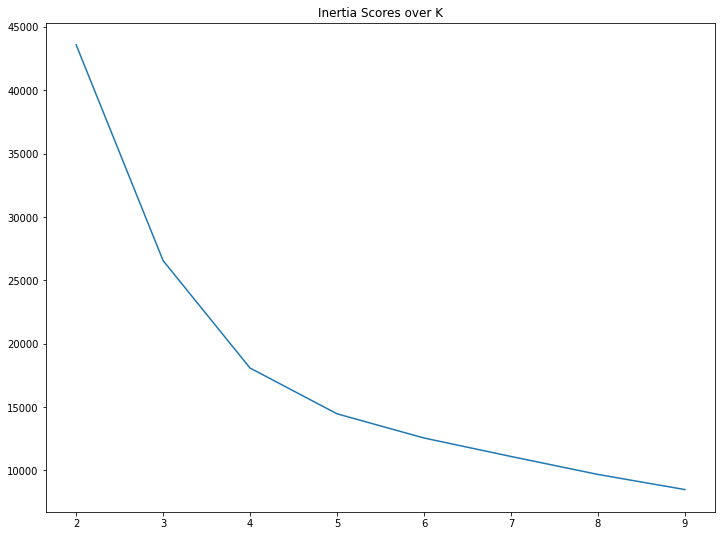

In [268]:
plot_inertia_score(X_tsne_sc_t)

## CVEC, TF-IDF and DBSCAN

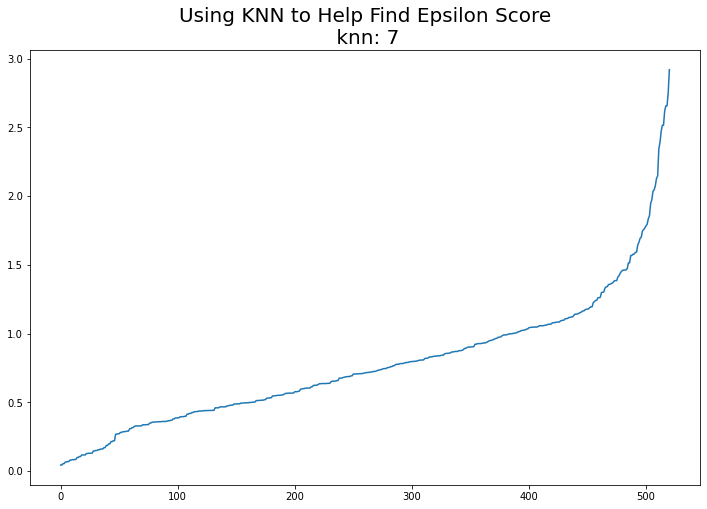

In [231]:
find_epsilon(X_tsne_t, 7)

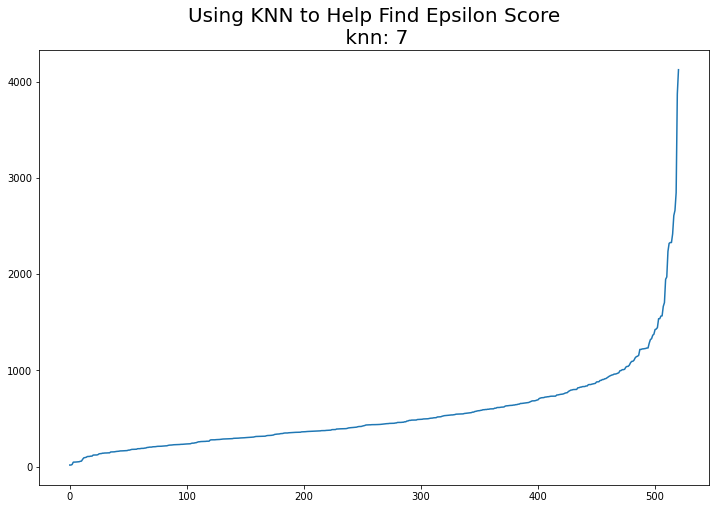

In [232]:
find_epsilon(X_c, 7)

In [233]:
find_scores_db(X_tsne_t, 1.4)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
-0.17331216363430266
--------------------
-1     343
 4      23
 1      22
 0      19
 6      18
 5      18
 3      16
 2      14
 8      11
 7      10
 11      7
 10      7
 9       7
 12      6
Name: dbscan_label, dtype: int64
--------------------


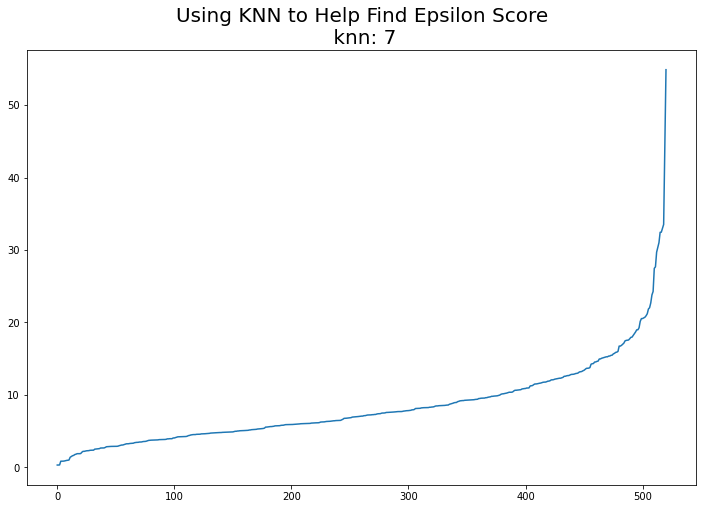

In [234]:
find_epsilon(X_sc_c, 7)

In [235]:
find_scores_db(X_sc_c, 18)

{0, -1}
0.07335318630924256
--------------------
 0    489
-1     32
Name: dbscan_label, dtype: int64
--------------------


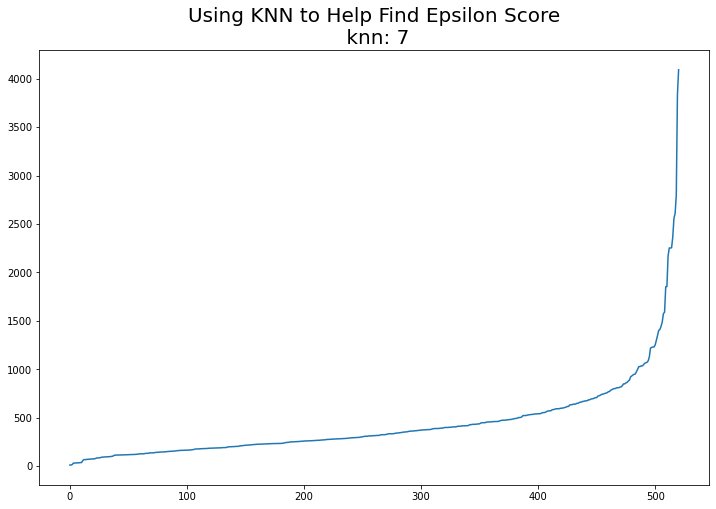

In [236]:
find_epsilon(X_pca_c, 7)

In [237]:
find_scores_db(X_pca_c, 1500)

{0, -1}
0.05968682029016115
--------------------
 0    507
-1     14
Name: dbscan_label, dtype: int64
--------------------


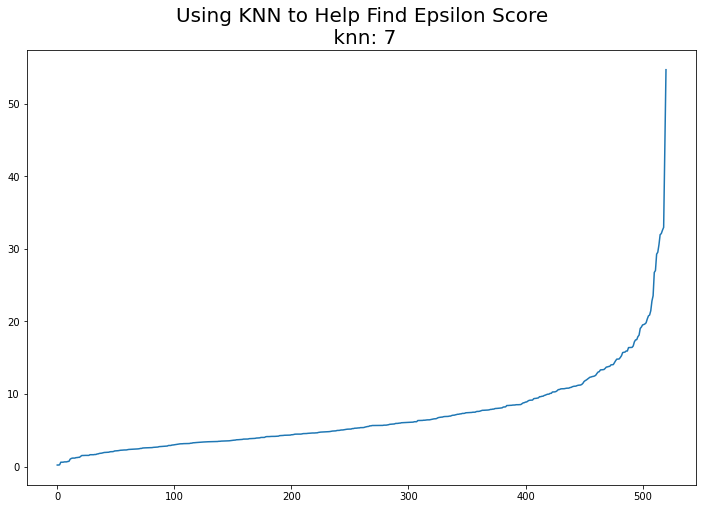

In [238]:
find_epsilon(X_pca_sc_c, 7)

In [239]:
find_scores_db(X_pca_sc_c, 18)

{0, -1}
0.08055669457762471
--------------------
 0    497
-1     24
Name: dbscan_label, dtype: int64
--------------------


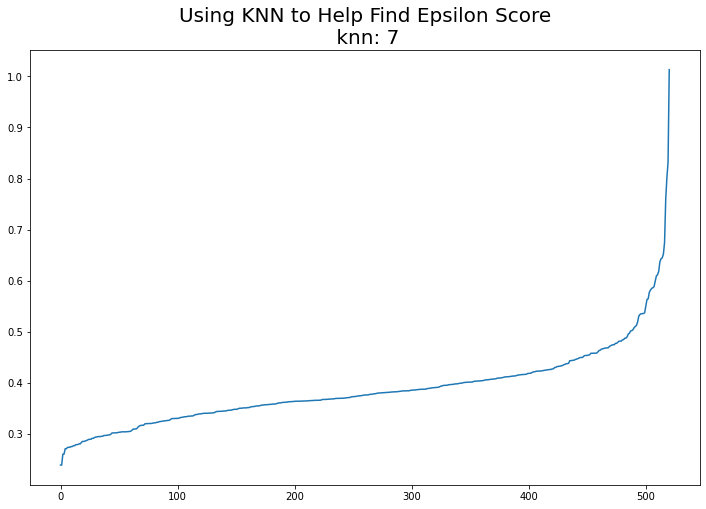

In [240]:
find_epsilon(X_t, 7)

In [241]:
find_scores_db(X_t, 0.5)

{0, -1}
0.20969538941996518
--------------------
 0    486
-1     35
Name: dbscan_label, dtype: int64
--------------------


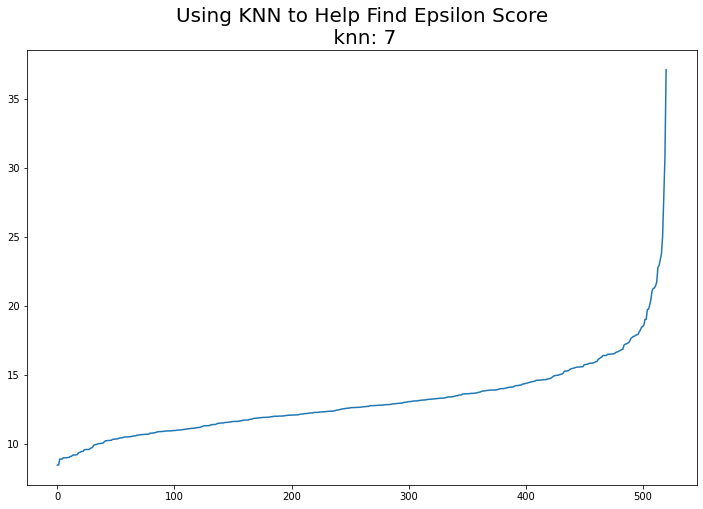

In [242]:
find_epsilon(X_sc_t, 7)

In [243]:
find_scores_db(X_sc_t, 18)

{0, -1}
0.244243238022162
--------------------
 0    497
-1     24
Name: dbscan_label, dtype: int64
--------------------


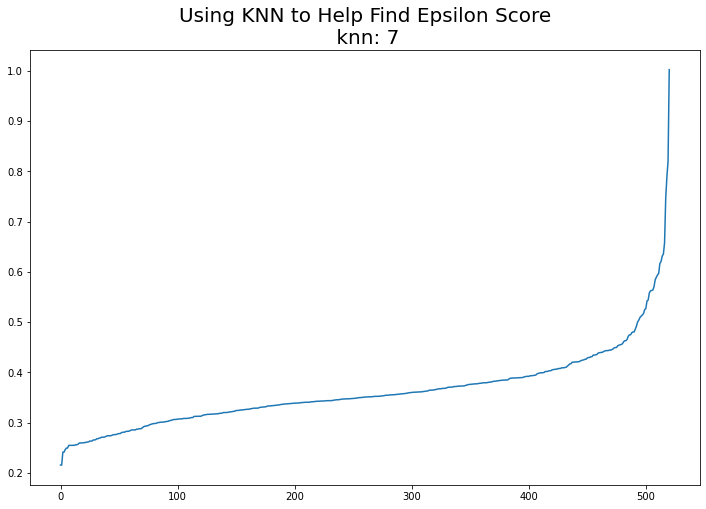

In [244]:
find_epsilon(X_pca_t, 7)

In [245]:
find_scores_db(X_pca_t, 0.45)

{0, -1}
0.1783601391352314
--------------------
 0    473
-1     48
Name: dbscan_label, dtype: int64
--------------------


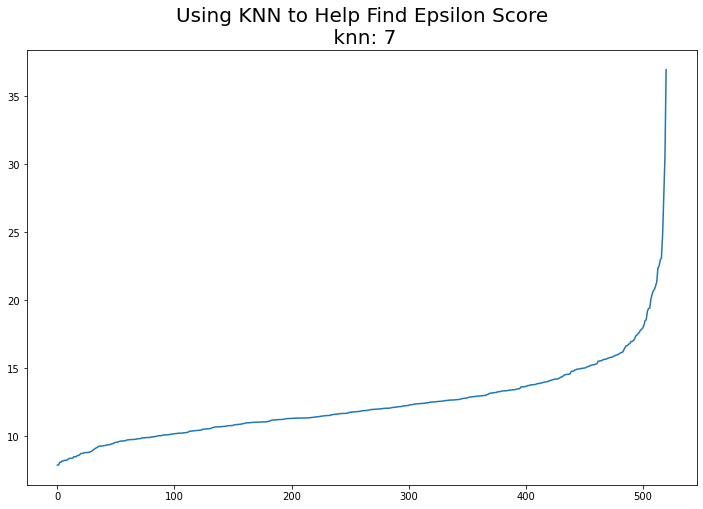

In [246]:
find_epsilon(X_pca_sc_t, 7)

**CVEC and DBSCAN as well as TF-IDF and DBSCAN did not produce good models as illustrated by the silhouette scores. DBSCAN will not, therefore, be pursued or discussed further.**

## Cosine Similarity

In [248]:
# Get the cosine similarity for each document
# Help from Kelly Slatery
# Looking at the first 50 documents
vector_distances = pd.DataFrame(pairwise_distances(X_tsne_pca_sc_c[:50], X_tsne_pca_sc_c[:50], metric='cosine'))
vector_distances.corr().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.999013,0.971070,0.997431,0.972539,0.998664,0.913769,0.984053,0.999624,0.998490,0.994817,0.999230,0.981602,0.563457,0.983904,0.941206,0.991468,0.691915,0.978560,0.999301,-0.044579,0.826812,0.858405,0.979647,0.247752,0.999937,0.941323,0.914697,-0.950343,0.970880,-0.518526,0.999442,0.812628,0.981543,0.998768,0.998850,-0.973072,0.184231,0.996658,-0.725170,-0.831241,0.923180,-0.990412,0.998141,-0.865145,0.999546,0.980225,0.959767,-0.998840,-0.660045
1,0.999013,1.000000,0.959505,0.993264,0.981917,0.995383,0.930912,0.990983,0.999856,0.999945,0.998352,0.999986,0.989114,0.599599,0.974995,0.925270,0.984699,0.723303,0.968445,0.996655,-0.088911,0.850981,0.834772,0.987596,0.290542,0.999448,0.925402,0.895842,-0.935581,0.980563,-0.480032,0.999939,0.837714,0.972079,0.999986,0.995734,-0.982350,0.227709,0.999303,-0.693868,-0.855115,0.905196,-0.983298,0.994448,-0.886569,0.997220,0.970467,0.946347,-0.999993,-0.692763
2,0.971070,0.959505,1.000000,0.985682,0.888826,0.982111,0.790328,0.913110,0.964153,0.956486,0.941756,0.960956,0.907609,0.349879,0.998112,0.994650,0.993912,0.499495,0.999433,0.979317,0.195266,0.668576,0.956066,0.903373,0.009236,0.968331,0.994685,0.984741,-0.997163,0.885585,-0.707709,0.962551,0.649955,0.998815,0.958022,0.981403,-0.889879,-0.055805,0.948318,-0.868617,-0.674446,0.988257,-0.994748,0.983819,-0.720357,0.977827,0.999121,0.999054,-0.958444,-0.461562
3,0.997431,0.993264,0.985682,1.000000,0.953367,0.999800,0.882320,0.968783,0.995090,0.991989,0.984977,0.993853,0.965401,0.502827,0.994178,0.962989,0.998259,0.638417,0.990800,0.999411,0.027101,0.784394,0.892948,0.962750,0.177712,0.996564,0.963083,0.941298,-0.970195,0.951223,-0.578448,0.994481,0.768792,0.992721,0.992646,0.999718,-0.954059,0.113347,0.988245,-0.772634,-0.789282,0.948343,-0.997764,0.999943,-0.826995,0.999137,0.991883,0.977417,-0.992824,-0.604534
4,0.972539,0.981917,0.888826,0.953367,1.000000,0.959214,0.983223,0.998428,0.978558,0.983855,0.991163,0.980920,0.999085,0.740262,0.915295,0.836731,0.933903,0.840949,0.903752,0.963160,-0.275865,0.935019,0.715442,0.999462,0.466434,0.975088,0.836921,0.795518,-0.851815,0.999975,-0.305278,0.979771,0.925950,0.910078,0.982891,0.960261,-0.999997,0.407929,0.988301,-0.544997,-0.937798,0.808370,-0.931062,0.956545,-0.958112,0.965081,0.907250,0.868057,-0.982618,-0.816761


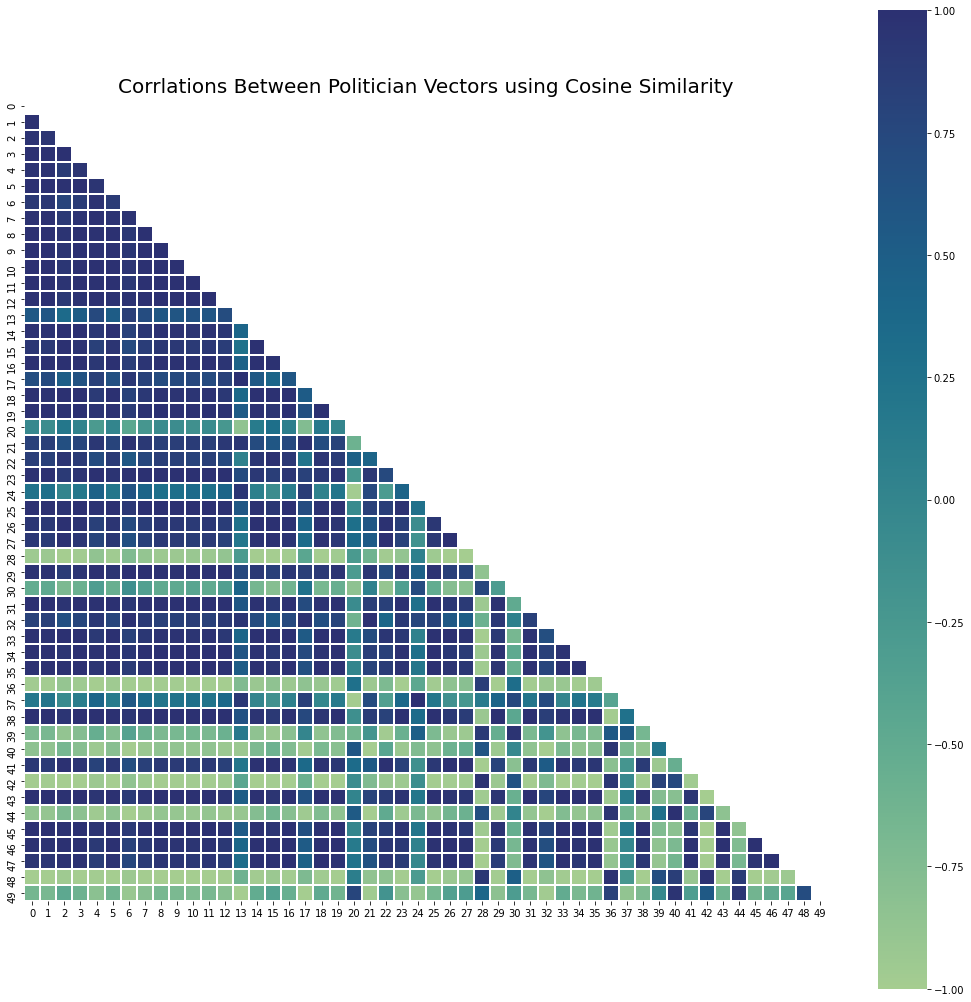

In [249]:
# Seeing correlations between first 50 documents (dataset is too large with all documents) using cosine similarity
plt.figure(figsize=(18,18))

corr = vector_distances.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap='crest', 
            vmax=1, 
            vmin=-1, 
            linecolor='white', 
            linewidths=1,
            square=True, 
           mask=mask)

plt.title('Corrlations Between Politician Vectors using Cosine Similarity', size=20)

plt.show()

In [250]:
# count the most frequently occuring words 

# dictionary to hold column header, count (key, value)
freq_words = {}

# loop through columns
for col in X_c.columns:
    
    # save sum of each column in dictionary
    freq_words[col] = X_c[col].sum()  
    
# save dictionary words in a dataframe
most_common = pd.DataFrame(sorted(freq_words.items(), key = lambda x: x[1], reverse = True))

most_common[:20]


,0,1
0,today,136868
1,work,128641
2,need,115104
3,trump,100434
4,help,100053
5,people,92826
6,act,92378
7,president,91200
8,thank,89566
9,community,88413


### Exporting the Best CVEC model cluster labels

In [269]:
# CVEC

# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters=2, random_state=516)
km.fit(X_tsne_pca_sc_c)
km_means = km.predict(X_tsne_pca_sc_c)

print(set(km.labels_))

print(silhouette_score(X_tsne_pca_sc_c, km.labels_))

print('--------------------')

data['km_label_cvec'] = km.labels_

print(data['km_label_cvec'].value_counts())

print('--------------------')


{0, 1}
0.5465951
--------------------
0    278
1    243
Name: km_label_cvec, dtype: int64
--------------------


### Exporting the Best CVEC model cluster labels

In [270]:
# TVEC

# Based on above information, fit model w/ info
# from model w/ best silhouette & inertia scores to get labels
# add cluster labels to dataframe

km = KMeans(n_clusters=2, random_state=516)
km.fit(X_tsne_sc_t)
km_means = km.predict(X_tsne_sc_t)

print(set(km.labels_))

print(silhouette_score(X_tsne_sc_t, km.labels_))

print('--------------------')

data['km_label_tvec'] = km.labels_

print(data['km_label_tvec'].value_counts())

print('--------------------')

{0, 1}
0.49170032
--------------------
1    270
0    251
Name: km_label_tvec, dtype: int64
--------------------


In [253]:
data.head(2)

,screen_name,state,position,name,party,tweet_count,text_concat_clean,liststring,vectors,text_length,word_length,km_label,dbscan_label,km_label_cvec,km_label_tvec
0,CongressmanRaja,IL,Representative,Raja Krishnamoorthi,D,4845,"['tonight', 'president', 'stage', 'elaborate',...",'tonight' 'president' 'stage' 'elaborate' 'pho...,"[-0.2115751579, 0.39771672760000004, 0.0444499...",1623390,178283,1,0,0,1
1,RepMcGovern,MA,Representative,James McGovern,D,3587,"['hell', 'Donald', 'Trump', 'think', 'teargass...",'hell' 'Donald' 'Trump' 'think' 'teargasse' 'p...,"[-0.20878361280000002, 0.39065130130000003, 0....",1313476,154634,1,0,0,1


## Exporting Dataframe with cluster labels

In [271]:
# # Exporting in google colab. Update directory as needed.
# data.to_csv('/content/drive/MyDrive/Python/vectors_labels_df.csv', index=False)

# Export dataframe with kmeans and dbscan labels
data.to_csv('./data/vectors_labels_df.csv', index=False)